In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# YOUR CODE HERE
# Set the ticker
list_of_tickers = ["SPY", "AGG"]
# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
#end_date = datetime.now()
#start_date = end_date + timedelta(-365*100)

start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-01-02', tz='America/New_York').isoformat()
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df = df.sort_index()
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df = df.droplevel(axis=1, level=1)
df.index = df.index.date
df.dropna(inplace=True)
df.head()

,AGG,SPY
2019-01-02,106.585,249.89
2019-01-03,107.020,244.46
2019-01-04,106.695,252.41
2019-01-07,106.470,254.40
2019-01-08,106.420,256.65


In [5]:
df.count()

AGG    253
SPY    253
dtype: int64

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [6]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
daily_returns = df.pct_change()
daily_returns.dropna(inplace=True)
daily_returns.head()
agg_mean = daily_returns.mean()['AGG']
spy_mean = daily_returns.mean()['SPY']
print('AGG mean:',agg_mean)
print('Spy mean:',spy_mean)

AGG mean: 0.00022270586670078947
Spy mean: 0.0010721152074640258


In [7]:
# Calculate volatility
# YOUR CODE HERE

agg_std = daily_returns.std()['AGG']
spy_std = daily_returns.std()['SPY']
print('AGG std:',agg_std)
print('Spy std:',spy_std)

AGG std: 0.0020916117982658737
Spy std: 0.007820964517970708


In [8]:
# Save the last day's closing price
# YOUR CODE HERE
agg_last_day = df['AGG'][-1]
spy_last_day = df['SPY'][-1]

In [9]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [10]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    # YOUR CODE HERE
    
    # Initialize the simulated prices list with the last closing price of AGG and SPY
    simulated_agg_prices = [agg_last_day]
    simulated_spy_prices = [spy_last_day]
    
    for i in range(number_records):
        
        simulated_price_agg = simulated_agg_prices[-1] * (1 + np.random.normal(agg_mean, agg_std))
        simulated_price_spy = simulated_spy_prices[-1] * (1 + np.random.normal(spy_mean, spy_std))

        simulated_agg_prices.append(simulated_price_agg)
        simulated_spy_prices.append(simulated_price_spy)
    
    weights = [0.6,0.4]
    simulated_prices = pd.DataFrame()
    simulated_prices['AGG'] = pd.Series(simulated_agg_prices)
    simulated_prices['SPY'] = pd.Series(simulated_spy_prices)
    
    simulated_dr = simulated_prices.pct_change()
    simulated_dr.dropna(inplace=True)

    portfolio_daily_returns = simulated_dr.dot(weights)
    
    
    monte_carlo[x] = (1+portfolio_daily_returns.fillna(0)).cumprod()
    

    

In [11]:
monte_carlo.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,68.128227,61.614732,65.210741,56.338417,64.618861,107.468160,46.082652,76.973352,66.304854,60.857870,...,60.234544,73.738344,66.154777,58.904140,75.564105,119.151790,56.416964,119.203969,59.121452,63.254574
7557,68.024021,61.255813,65.126801,56.329388,64.638935,107.448092,45.871245,77.471021,66.272901,60.548412,...,60.109618,73.592508,66.274885,58.633344,75.587441,119.795140,56.582660,119.482241,59.325123,63.122794
7558,67.849049,61.214621,65.404374,56.391254,64.528897,107.766493,45.904687,77.685883,66.539086,60.537990,...,60.133719,73.797617,66.424448,58.558294,75.889840,119.754270,56.584141,118.807294,59.110319,63.159520
7559,67.753847,61.252417,65.500759,56.496694,64.896049,107.508643,45.834584,77.587072,66.313293,60.473187,...,60.261858,74.087832,66.093076,58.511304,76.178628,119.536533,56.729005,118.593421,58.916716,62.987566
7560,68.180864,61.503161,66.021304,56.693525,64.969116,107.552546,45.638122,77.455409,65.979626,60.438780,...,60.422631,73.947978,65.943788,58.687369,76.316921,119.560872,56.670255,117.936024,58.983260,63.217700


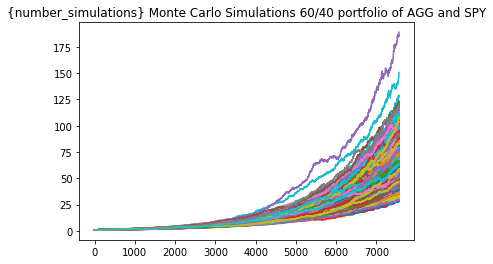

In [12]:
# Visualize the Simulation
# YOUR CODE HERE
monte_carlo.plot(legend=None, title='{number_simulations} Monte Carlo Simulations 60/40 portfolio of AGG and SPY')

In [13]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
cumulative_return_last30 = monte_carlo.iloc[-1]
cumulative_return_last30

0       68.180864
1       61.503161
2       66.021304
3       56.693525
4       64.969116
          ...    
495    119.560872
496     56.670255
497    117.936024
498     58.983260
499     63.217700
Name: 7560, Length: 500, dtype: float64

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
cumulative_return_last20 = monte_carlo.iloc[252*20]
cumulative_return_last20

0      16.197499
1      15.604881
2      14.076241
3      13.846569
4      21.075151
         ...    
495    26.551382
496    16.952731
497    27.740591
498    11.922788
499    17.867672
Name: 5041, Length: 500, dtype: float64

In [15]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
confidence_interval = cumulative_return_last30.quantile([0.05,0.95])
confidence_interval

0.05     42.777984
0.95    104.819157
Name: 7560, dtype: float64

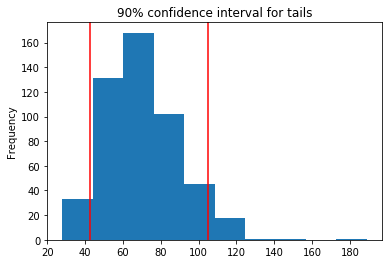

In [16]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE
plt.figure()
cumulative_return_last30.plot.hist(title="90% confidence interval for tails")
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [17]:
# YOUR CODE HERE
ten_perc = np.percentile(cumulative_return_last30,10)
fifty_perc = np.percentile(cumulative_return_last30,50)
ninety_perc = np.percentile(cumulative_return_last30,90)
print(f' expected cumulative returns at 30 years for the 10th: {round(ten_perc,2)}')
print(f' expected cumulative returns at 30 years for the 50th: {round(fifty_perc,2)}')
print(f' expected cumulative returns at 30 years for the 90th: {round(ninety_perc,2)}')


 expected cumulative returns at 30 years for the 10th: 46.3
 expected cumulative returns at 30 years for the 50th: 67.87
 expected cumulative returns at 30 years for the 90th: 95.64


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [18]:
# YOUR CODE HERE
init_invest = 20000.0
expected_10 = init_invest * ten_perc
expected_50 = init_invest * fifty_perc
expected_90 = init_invest * ninety_perc
print(f'Expected portfolio return in dollars at the 10th: ${round(expected_10,2)}')
print(f'Expected portfolio return in dollars at the 50th: ${round(expected_50,2)}')
print(f'Expected portfolio return in dollars at the 10th: ${round(expected_90,2)}')

Expected portfolio return in dollars at the 10th: $926057.5
Expected portfolio return in dollars at the 50th: $1357411.31
Expected portfolio return in dollars at the 10th: $1912779.02


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [19]:
# YOUR CODE HERE
proj_income = 7389.0
wd_amount = 0.04 * (init_invest * np.quantile(cumulative_return_last30, 0.1)) 
print(f'4% withdraw rate: ${wd_amount}')
if wd_amount >= proj_income:
    print('Yes')
else:
    print('No')

4% withdraw rate: $37042.30008744132
Yes


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [20]:
# YOUR CODE HERE
# YOUR CODE HERE
proj_income = 7389.0
wd_amount = 0.04 * (init_invest * 1.5 * np.quantile(cumulative_return_last30, 0.1)) 
print(f'4% withdraw rate (+50%): ${wd_amount}')
if wd_amount >= proj_income:
    print('Yes')
else:
    print('No')

4% withdraw rate (+50%): $55563.450131161975
Yes


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

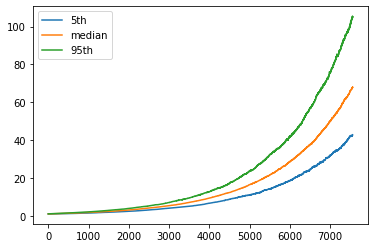

In [21]:
# YOUR CODE HERE
quant_df=monte_carlo.quantile(q=[0.05,0.5,0.95],axis=1)
invest_df=pd.DataFrame(quant_df*init_invest)
fig = quant_df.iloc[0].plot()
fig.plot(quant_df.iloc[1])
fig.plot(quant_df.iloc[2])
fig.legend(['5th','median','95th'])